# Outlook
In this notebook, using BBRL, we code a simple version of the DQN algorithm
without a replay buffer nor a target network so as to better understand the
inner mechanisms.

To understand this code, you need to know more about 
[the BBRL interaction model](https://colab.research.google.com/drive/1_yp-JKkxh_P8Yhctulqm0IrLbE41oK1p?usp=sharing).
Then you should run [a first example](https://colab.research.google.com/drive/1Ui481r47fNHCQsQfKwdoNEVrEiqAEokh?usp=sharing)
to see how agents interact.

The DQN algorithm is explained in [this
video](https://www.youtube.com/watch?v=CXwvOMJujZk) and you can also read [the
corresponding slides](http://pages.isir.upmc.fr/~sigaud/teach/dqn.pdf).

## Installation and Imports

### Installation

The BBRL library is [here](https://github.com/osigaud/bbrl).

We use OmegaConf to that makes it possible that by just defining the `def
run_dqn(cfg):` function and then executing a long `params = {...}` variable at
the bottom of this colab, the code is run with the parameters without calling
an explicit main.

More precisely, the code is run by calling

`config=OmegaConf.create(params)`

`run_dqn(config)`

at the very bottom of the colab, after starting tensorboard.

Below, we import standard python packages, pytorch packages and gymnasium
environments.

In [1]:
# Installs the necessary Python and system libraries
try:
    from easypip import easyimport, easyinstall, is_notebook
except ModuleNotFoundError as e:
    get_ipython().run_line_magic("pip", "install easypip")
    from easypip import easyimport, easyinstall, is_notebook

easyinstall("bbrl>=0.2.2")
easyinstall("swig")
easyinstall("bbrl_gymnasium>=0.2.0")
easyinstall("bbrl_gymnasium[box2d]")
easyinstall("bbrl_gymnasium[classic_control]")
easyinstall("tensorboard")
easyinstall("moviepy")
easyinstall("box2d-kengz")

In [2]:
import os
import sys
from pathlib import Path
import math

from moviepy.editor import ipython_display as video_display
import time
from tqdm.auto import tqdm
from typing import Tuple, Optional
from functools import partial

from omegaconf import OmegaConf
import torch
import bbrl_gymnasium

import copy
from abc import abstractmethod, ABC
import torch.nn as nn
import torch.nn.functional as F
from time import strftime
OmegaConf.register_new_resolver(
    "current_time", lambda: strftime("%Y%m%d-%H%M%S"), replace=True
)

In [3]:
# Imports all the necessary classes and functions from BBRL
from bbrl.agents.agent import Agent
from bbrl import get_arguments, get_class, instantiate_class
# The workspace is the main class in BBRL, this is where all data is collected and stored
from bbrl.workspace import Workspace

# Agents(agent1,agent2,agent3,...) executes the different agents the one after the other
# TemporalAgent(agent) executes an agent over multiple timesteps in the workspace, 
# or until a given condition is reached
from bbrl.agents import Agents, TemporalAgent

# ParallelGymAgent is an agent able to execute a batch of gymnasium environments
# with auto-resetting. These agents produce multiple variables in the workspace:
# ’env/env_obs’, ’env/reward’, ’env/timestep’, ’env/terminated’,
# 'env/truncated', 'env/done', ’env/cumulated_reward’, ... 
# 
# When called at timestep t=0, the environments are automatically reset. At
# timestep t>0, these agents will read the ’action’ variable in the workspace at
# time t − 1
from bbrl.agents.gymnasium import GymAgent, ParallelGymAgent, make_env, record_video

# Replay buffers are useful to store past transitions when training
from bbrl.utils.replay_buffer import ReplayBuffer

In [4]:
# Utility function for launching tensorboard
# For Colab - otherwise, it is easier and better to launch tensorboard from
# the terminal
def setup_tensorboard(path):
    path = Path(path)
    answer = ""
    if is_notebook():
        if get_ipython().__class__.__module__ == "google.colab._shell":
            answer = "y"
        while answer not in ["y", "n"]:
                answer = input(f"Do you want to launch tensorboard in this notebook [y/n] ").lower()

    if answer == "y":
        get_ipython().run_line_magic("load_ext", "tensorboard")
        get_ipython().run_line_magic("tensorboard", f"--logdir {path.absolute()}")
    else:
        import sys
        import os
        import os.path as osp
        print(f"Launch tensorboard from the shell:\n{osp.dirname(sys.executable)}/tensorboard --logdir={path.absolute()}")

## Definition of agents

After running the simple BBRL interaction notebook pointed to above, have a look at
[this more advanced notebook](https://colab.research.google.com/drive/1Ui481r47fNHCQsQfKwdoNEVrEiqAEokh?usp=sharing)
where the agents is a simple random agent and the environment agent is [the CartPole-v1 gym environment](https://gymnasium.farama.org/environments/classic_control/cart_pole/).
We provide just a few details below.

In BBRL, the agent and the environment act within a **workspace** by *reading*
and *writing* information:

- **reading**: by using `self.get((key, t))` to get the value of the tensor
  identified by `key` (a string)
- **writing**: by using `self.set((key, t), y)` to set the value of the tensor
  identified by `key` to `y`

**WARNING**: we are working with batches (i.e. several episodes at the same
time)

An episode is depicted in the figure below.

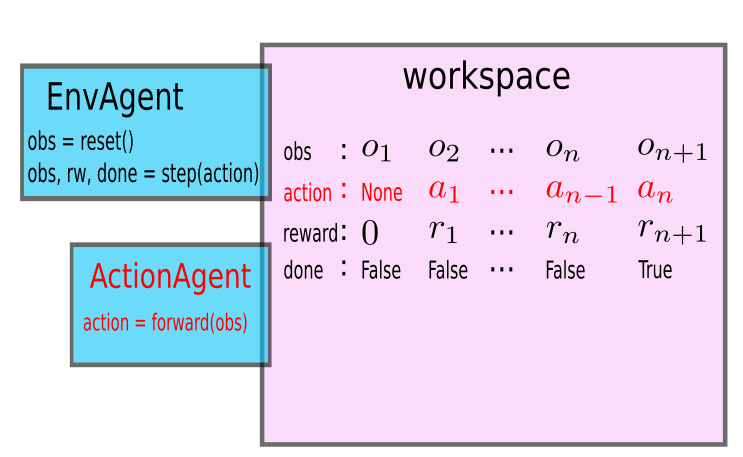

Note that, as depicted below, the reward indexing scheme we use here consists in getting $r_{t+1}$ after performing action $a_t$ from state $s_t$.

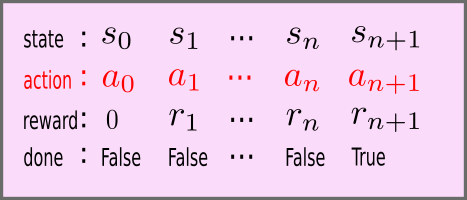

[This notebook](https://colab.research.google.com/drive/1Cld72_FBA1aMS2U4EsyV3LGZIlQC_PsC?usp=sharing#scrollTo=qXvH0jNADUsY) explains that another choice is possible.

To showcase BBRL, let us go through the CartPole environment

In [5]:
# We run episodes over 3 environments at a time
n_envs = 3
env_agent = ParallelGymAgent(partial(make_env, 'CartPole-v1', autoreset=False), n_envs, reward_at_t=False)
# The random seed is set to 2139
env_agent.seed(2139)

obs_size, action_dim = env_agent.get_obs_and_actions_sizes()
print(f"Environment: observation space in R^{obs_size} and action space {{1, ..., {action_dim}}}")

Environment: observation space in R^4 and action space {1, ..., 2}


In [6]:
# Creates a new workspace
workspace = Workspace() 

# Execute the first step
env_agent(workspace, t=0)

# Our first set of observations. The size of the observation space is 4, and we have 3 environments.
obs = workspace.get("env/env_obs", 0)
print("Observation", obs)

Observation tensor([[-0.0085, -0.0427, -0.0489,  0.0215],
        [ 0.0005,  0.0025, -0.0493, -0.0402],
        [ 0.0080,  0.0203, -0.0023, -0.0085]])


### Random action without agent
We first set an action directly without using an agent

In [7]:
# Sets the next action
action = torch.randint(0, action_dim, (n_envs, ))
workspace.set("action", 0, action)
print(action)
env_agent(workspace, t=1)

# And perform one step
workspace.get("env/env_obs", 1)

tensor([0, 1, 1])


tensor([[-0.0094, -0.2371, -0.0485,  0.2984],
        [ 0.0006,  0.1983, -0.0501, -0.3480],
        [ 0.0084,  0.2155, -0.0025, -0.3019]])

Let us now see the workspace

In [8]:
for key in workspace.variables.keys():
    print(key, workspace[key])

env/env_obs tensor([[[-0.0085, -0.0427, -0.0489,  0.0215],
         [ 0.0005,  0.0025, -0.0493, -0.0402],
         [ 0.0080,  0.0203, -0.0023, -0.0085]],

        [[-0.0094, -0.2371, -0.0485,  0.2984],
         [ 0.0006,  0.1983, -0.0501, -0.3480],
         [ 0.0084,  0.2155, -0.0025, -0.3019]]])
env/terminated tensor([[False, False, False],
        [False, False, False]])
env/truncated tensor([[False, False, False],
        [False, False, False]])
env/done tensor([[False, False, False],
        [False, False, False]])
env/reward tensor([[0., 0., 0.],
        [1., 1., 1.]])
env/cumulated_reward tensor([[0., 0., 0.],
        [1., 1., 1.]])
env/timestep tensor([[0, 0, 0],
        [1, 1, 1]])
action tensor([[0, 1, 1]])


You can observe that we have two time steps for each variable that are stored
within tensors where the first dimension is time. 

### Random agent

The process above can be
automatized with `Agents` and `TemporalAgent` as shown below - but first we have
to create an agent that selects the actions (here, random).

In [9]:
class RandomAgent(Agent):
    def __init__(self, action_dim):
        super().__init__()
        self.action_dim = action_dim

    def forward(self, t: int, choose_action=True, **kwargs):
        """An Agent can use self.workspace"""
        obs = self.get(("env/env_obs", t))
        action = torch.randint(0, self.action_dim, (len(obs), ))
        self.set(("action", t), action)

# Each agent is run in the order given when constructing Agents
agents = Agents(env_agent, RandomAgent(action_dim))

# And the TemporalAgent allows to run through time
t_agents = TemporalAgent(agents)

In [10]:
# We can now run the agents throught time with a simple call...

workspace = Workspace()
t_agents(workspace, t=0, stop_variable="env/done", stochastic=True)

### Termination

`env/done` tells us if the episode was finished or not
here, with NoAutoReset, (1) we wait that all episodes are "done",
and when an episode is finished the flag remains True.
Note that when an environment is done before the others, its content is copied until the termination of all environments.
This is convenient for collecting the final reward.

In [11]:
workspace["env/done"].shape, workspace["env/done"][-10:]

(torch.Size([56, 3]),
 tensor([[False,  True,  True],
         [False,  True,  True],
         [False,  True,  True],
         [False,  True,  True],
         [False,  True,  True],
         [False,  True,  True],
         [False,  True,  True],
         [False,  True,  True],
         [False,  True,  True],
         [ True,  True,  True]]))

The resulting tensor of observations, with the last two observations

In [12]:
workspace["env/env_obs"].shape, workspace["env/env_obs"][-2:]

(torch.Size([56, 3, 4]),
 tensor([[[ 0.1894,  1.5411, -0.1773, -2.1396],
          [-0.1207, -0.6043,  0.2165,  1.2958],
          [-0.0402, -0.3898,  0.2286,  1.0551]],
 
         [[ 0.2202,  1.7375, -0.2201, -2.4814],
          [-0.1207, -0.6043,  0.2165,  1.2958],
          [-0.0402, -0.3898,  0.2286,  1.0551]]]))

The resulting tensor of rewards, with the last 8 rewards

In [13]:
workspace["env/reward"].shape, workspace["env/reward"][-8:]

(torch.Size([56, 3]),
 tensor([[1., 0., 0.],
         [1., 0., 0.],
         [1., 0., 0.],
         [1., 0., 0.],
         [1., 0., 0.],
         [1., 0., 0.],
         [1., 0., 0.],
         [1., 0., 0.]]))

The resulting tensor of actions, with the last two actions

In [14]:
workspace["action"].shape, workspace["action"][-2:]

(torch.Size([56, 3]),
 tensor([[1, 1, 0],
         [0, 1, 1]]))

Some other details are available in the notebooks pointed above.

## Definition of agents

### The critic agent

The [DQN](https://daiwk.github.io/assets/dqn.pdf) algorithm is a critic only
algorithm. Thus we just need a Critic agent (which will also be used to output
actions) and an Environment agent. We use the `DiscreteQAgent` class also explained in [this
notebook](https://colab.research.google.com/drive/1Ui481r47fNHCQsQfKwdoNEVrEiqAEokh?usp=sharing).

The function below builds a multi-layer perceptron where the size of each layer is given in the `size` list.
We also specify the activation function of neurons at each layer and optionally a different activation function for the final layer.

In [15]:
import torch.nn as nn
def build_mlp(sizes, activation, output_activation=nn.Identity()):
    """Helper function to build a multi-layer perceptron (function from $\mathbb R^n$ to $\mathbb R^p$)
    
    Args:
        sizes (List[int]): the number of neurons at each layer
        activation (nn.Module): a PyTorch activation function (after each layer but the last)
        output_activation (nn.Module): a PyTorch activation function (last layer)
    """
    
    layers = []
    for j in range(len(sizes) - 1):
        act = activation if j < len(sizes) - 2 else output_activation
        layers += [nn.Linear(sizes[j], sizes[j + 1]), act]
    return nn.Sequential(*layers)

The `DiscreteQAgent` class implements a critic such as the one used in DQN.
It has one output neuron per action and its output is the Q-value of these actions given the state.
As any BBRL agent, it has a `forward()` function that takes a time state as input.
This `forward()` function outputs the Q-values at the corresponding time step.
Additionally, if the critic is used to choose an action, it also outputs the chosen action at the same time step.
Besides, it is also useful to get the network output (as a Q-value or as an action) given a state rather than a time step.
This is what the `predict_action` and `predict_value` functions are used for.

In [16]:
class DiscreteQAgent(Agent):
    """BBRL agent (discrete actions) based on a MLP"""
    def __init__(self, state_dim, hidden_layers, action_dim):
        super().__init__()
        self.model = build_mlp(
            [state_dim] + list(hidden_layers) + [action_dim], activation=nn.ReLU()
        )

    def forward(self, t: int, choose_action=True, **kwargs):
        """An Agent can use self.workspace"""

        # Retrieves the observation from the environment at time t
        obs = self.get(("env/env_obs", t))

        # Computes the critic (Q) values for the observation
        q_values = self.model(obs)

        # ... and sets the q-values (one for each possible action)
        self.set(("q_values", t), q_values)

        # Flag to toggle the fact that the action is chosen
        # by this agent; otherwise, we use a specific agent
        # (ex. epsilon-greedy) that implements the current policy,
        # see below (Exploration method)
        if choose_action:
            action = q_values.argmax(1)
            self.set(("action", t), action)

### Creating an Exploration method

As Q-learning, DQN needs some exploration to prevent too early convergence.
Here we use the simple $\epsilon$-greedy exploration method. The method
is implemented as an agent which chooses an action based on the Q-values.

In [17]:
class EGreedyActionSelector(Agent):
    def __init__(self, epsilon):
        super().__init__()
        self.epsilon = epsilon

    def forward(self, t: int, **kwargs):
        # Retrieves the q values 
        # (matrix nb. of episodes x nb. of actions)
        q_values = self.get(("q_values", t))
        size, nb_actions = q_values.size()

        # Flag 
        is_random = torch.rand(size).lt(self.epsilon).float()
        random_action = torch.randint(low=0, high=nb_actions, size=(size,))
        max_action = q_values.max(1)[1]

        # Choose the action based on the is_random flag
        action = is_random * random_action + (1 - is_random) * max_action

        # Sets the action at time t
        self.set(("action", t), action.long())

### Training and evaluation environments

In actor-critic algorithms relying on a replay buffer, the actor can be
trained at each step during an episode. Besides, the training signal is the
reward obtained during these episodes. So it may seem natural to display a
learning curve corresponding to the performance of the training agent along
the set of training episodes.

But let us think of it. If the agent is changing during an episode, which
agent are we truly evaluating? The one in the beginning of the episode? In the
middle? In the end? We see that such evaluations based on an evolving agent
makes no sense.

What makes more sense is to train an agent for a number of steps, 
evaluate it on a few episode to determine the performance of the obtained
agent, then start again training. With this approach, the learning
curve makes more sense, it shows the evolving performance of a succession of
agents obtained after training sequences.

Separating training and evaluation provides additional opportunities. Often,
we will train the agent using exploration, but we will evaluate it in a
greedy, deterministic mode. Indeed, if the problem is truly an MDP, a
deterministic policy can be optimal.

Thus, in the general case, **we use two environments**: one for training and another one for evaluation.
The same agent is connected to these two environments in two instances of
TemporalAgent so that we train and evaluate the same network.

In the context of this notebook, none of the environment agents uses autoreset.

In practice, it is more efficient for training to use an AutoResetGymAgent, as we do not
want to waste time if the task is done in an environment sooner than in the
others, but this is more involved so we keep this for the advanced version of this notebook.

By contrast, for evaluation, we just need to perform a fixed number of
episodes (for statistics), thus it is more convenient to use a
NoAutoResetGymAgent with a set of environments and just run one episode in
each environment. Thus we can use the `env/done` stop variable and take
the average over the cumulated reward of all environments.

Finally, to keep the story simple, we use a single environment for training.

More details about using autoreset=True versus autoreset=False are given in [this
notebook](https://colab.research.google.com/drive/1EX5O03mmWFp9wCL_Gb_-p08JktfiL2l5?usp=sharing).

In [18]:
from typing import Tuple
from bbrl.agents.gymnasium import make_env, GymAgent, ParallelGymAgent
from functools import partial

def get_env_agents(cfg) -> Tuple[GymAgent, GymAgent]:
    # Returns a pair of environments (train / evaluation) based on a configuration `cfg`
    
    # Train environment
    train_env_agent = ParallelGymAgent(
        partial(make_env,  cfg.gym_env.env_name, autoreset=False),
        cfg.algorithm.n_envs
    ).seed(cfg.algorithm.seed)

    # Test environment
    eval_env_agent = ParallelGymAgent(
        partial(make_env, cfg.gym_env.env_name), 
        cfg.algorithm.nb_evals
    ).seed(cfg.algorithm.seed)

    return train_env_agent, eval_env_agent

### Create the DQN agents

We use the power of BBRL here to define the agents:

- `Agents` is a container that executes its contained agent in
  turn (so we can first run one step of the environment, then the critic and
  the explorer)
- `TemporalAgent` is just a container for a loop over time (it calls its contained agent
  and then steps to the next timestep `t+1`)

Interestingly, the loop between the policy and the environment is first
defined as a collection of agents, and then embedded into a single
TemporalAgent.

In [19]:
def create_dqn_agent(cfg, train_env_agent, eval_env_agent) -> Tuple[TemporalAgent, TemporalAgent]:
    # Get the observation / action state space dimensions
    obs_size, act_size = train_env_agent.get_obs_and_actions_sizes()

    # Our discrete Q-Agent    
    critic = DiscreteQAgent(obs_size, cfg.algorithm.architecture.hidden_size, act_size)

    # The agent used for training
    explorer = EGreedyActionSelector(cfg.algorithm.epsilon)
    q_agent = TemporalAgent(critic)
    tr_agent = Agents(train_env_agent, critic, explorer)
    train_agent = TemporalAgent(tr_agent)

    # The agent used for evaluation
    ev_agent = Agents(eval_env_agent, critic)
    eval_agent = TemporalAgent(ev_agent)
    
    return train_agent, eval_agent, q_agent

### The Logger class

The logger is in charge of collecting statistics during the training
process.

Having logging provided under the hood is one of the features allowing you
to save time when using RL libraries like BBRL.

In these notebooks, the logger is defined as `bbrl.utils.logger.TFLogger` so as
to use a tensorboard visualisation (see the parameters part `params = { "logger":{ ...` below).

Note that the BBRL Logger is also saving the log in a readable format such
that you can use `Logger.read_directories(...)` to read multiple logs, create
a dataframe, and analyze many experiments afterward in a notebook for
instance. The code for the different kinds of loggers is available in the
[bbrl/utils/logger.py](https://github.com/osigaud/bbrl/blob/master/src/bbrl/utils/logger.py)
file.

`instantiate_class` is an inner BBRL mechanism. The
`instantiate_class`function is available in the
[`bbrl/__init__.py`](https://github.com/osigaud/bbrl/blob/master/src/bbrl/__init__.py)
file.

In [20]:
from bbrl import instantiate_class

class Logger():

    def __init__(self, cfg):
        self.logger = instantiate_class(cfg.logger)

    def add_log(self, log_string, loss, steps):
        self.logger.add_scalar(log_string, loss.item(), steps)

    # A specific function for RL algorithms having a critic, an actor and an entropy losses
    def log_losses(self, critic_loss, entropy_loss, actor_loss, steps):
        self.add_log("critic_loss", critic_loss, steps)
        self.add_log("entropy_loss", entropy_loss, steps)
        self.add_log("actor_loss", actor_loss, steps)

    def log_reward_losses(self, rewards, nb_steps):
        self.add_log("reward/mean", rewards.mean(), nb_steps)
        self.add_log("reward/max", rewards.max(), nb_steps)
        self.add_log("reward/min", rewards.min(), nb_steps)
        self.add_log("reward/median", rewards.median(), nb_steps)

## Heart of the algorithm
### Computing the critic loss
The role of the `compute_critic_loss` function is to implement the Bellman
backup rule. In Q-learning, this rule was written:

$$Q(s_t,a_t) \leftarrow Q(s_t,a_t) + \alpha [ r(s_t,a_t) + \gamma \max_a
Q(s_{t+1},a) - Q(s_t,a_t)]$$

In DQN, the update rule $Q \leftarrow Q + \alpha [\delta] $ is replaced by a
gradient descent step over the Q-network. 

We first compute a target value: $ target = r(s_t,a_t) + \gamma \max_a
Q(s_{t+1},a)$ from a set of samples.

Then we get a TD error $\delta$ by substracting $Q(s_t,a_t)$ for these samples, 
and we use the squared TD error as a loss function: $ loss = (target -
Q(s_t,a_t))^2$.

To implement the above calculation in BBRL, the difficulty is to
properly deal with time indexes.

The `compute_critic_loss` function receives rewards, q_values and actions as
vectors (in practice, pytorch tensors) that have been computed over a complete
episode.

We need to take `reward[1:]`, which means all the rewards but the first one,
as explained in [this
notebook](https://colab.research.google.com/drive/1Cld72_FBA1aMS2U4EsyV3LGZIlQC_PsC?usp=sharing).
Similarly, to get $\max_a Q(s_{t+1}, a)$, we need to ignore the first of the
max_q values, using `max_q[1:]`.

Note the `max_q[0].detach()` in the computation of the temporal difference
target. First, the max_q[0] is because the max function returns both the max
and the indexes of the max. Second, about the .detach(), the idea is that we
compute this target as a function of $\max_a Q(s_{t+1}, a)$, but **we do not
want to apply gradient descent on this $\max_a Q(s_{t+1}, a)$**, we only
apply gradient descent to $Q(s_t, a_t)$ according to this target value. In
practice, `x.detach()` detaches a computation graph from a tensor, so it
avoids computing a gradient over this tensor.

The `must_bootstrap` tensor is used as a trick to deal with terminal states.
If the state is terminal, $Q(s_{t+1}, a)$ does not make sense. Thus we need to
ignore this term. So we multiply the term by `must_bootstrap`: if
`must_bootstrap` is True (converted into a float, it becomes a 1), we get the
term. If `must_bootstrap` is False (=0), we are at a terminal state, so we
ignore the term. This trick is used in many RL libraries, e.g. SB3. In [this
notebook](https://colab.research.google.com/drive/1erLbRKvdkdDy0Zn1X_JhC01s1QAt4BBj?usp=sharing)
we explain how to compute `must_bootstrap` so as to properly deal with time
limits. In this version we use full episodes, thus `must_bootstrap` will
always be True for all steps but the last one.

To compute $Q(s_t,a_t)$ we use the `torch.gather()` function. This function is
a little tricky to use, see [this
page](https://medium.com/analytics-vidhya/understanding-indexing-with-pytorch-gather-33717a84ebc4)
for useful explanations.

In particular, the q_vals output that we get is not properly conditioned,
hence the need for the `qval[:-1]` (we ignore the last dimension). Finally we
just need to compute the difference target - qvals, square it, take the mean
and send it back as the loss.

In [29]:
# For the tensor dimensions
# T = maximum number of time steps
# B = number of episodes run in parallel 
# A = state space dimension

def compute_critic_loss(cfg, reward: torch.Tensor, must_bootstrap: torch.Tensor, q_values: torch.Tensor, action: torch.LongTensor):
    """Compute the temporal difference loss from a dataset to update a critic

    Args:
        cfg (_type_): _description_ reward (torch.Tensor): A (T x B) tensor containing the rewards
        must_bootstrap (torch.Tensor): a (T x B) tensor containing 0 if the episode is completed at time $t$ 
        q_values (torch.Tensor): a (T x B x A) 
        action (torch.LongTensor): a (T) long tensor containing the chosen action

    Returns:
        torch.Scalar: The DQN loss
    """
    # We compute the max of Q-values over all actions (dimension 1, hence max(1))
    # and detach (so that this part of the computation graph is not included
    # in the gradient backpropagation)

    # Calculer la loss

    q = q_values.gather(dim=2,index=action.unsqueeze(-1)).squeeze(-1)
    qt,_ = q_values[1:].max(dim=2)
    qt = qt * must_bootstrap[:-1]
    qt = qt.detach()

    target = reward[1:] + qt

    mse = nn.MSELoss()
    critic_loss = mse(target, q[:-1])
    print(f' critic_loss : {critic_loss} \n q :  {q.shape} \n qt : { qt.shape } \n target : {target.shape} ')
    return critic_loss.mean()

### Setting up the optimizer

The optimizer is used to tune the parameters of the DQN agent.

In [23]:
# Configure the optimizer over the q agent
def setup_optimizer(cfg, q_agent):
    optimizer_args = get_arguments(cfg.optimizer)
    parameters = q_agent.parameters()
    optimizer = get_class(cfg.optimizer)(parameters, **optimizer_args)
    return optimizer

## Main training loop

Note that everything about the shared workspace between all the agents is
completely hidden under the hood. This results in a gain of productivity, at
the expense of having to dig into the BBRL code if you want to understand the
details, change the multiprocessing model, etc.

### Agent execution

This is the tricky part with BBRL, the one we need to understand in detail.
The difficulty lies in the copy of the last step and the way to deal with the
n_steps return.

`optimizer.zero_grad()` is necessary to cancel all the gradients computed at
the previous iterations

In [24]:
def run_dqn(cfg):
    # 1)  Build the  logger
    logger = Logger(cfg)
    best_reward = float('-inf')

    # 2) Create the environment agent
    train_env_agent, eval_env_agent = get_env_agents(cfg)
    
    # 3) Create the DQN Agent
    train_agent, eval_agent, q_agent = create_dqn_agent(
        cfg, train_env_agent, eval_env_agent
    )

    # Note that no parameter is needed to create the workspace.
    # In the training loop, calling the train_agent
    # will take the workspace as parameter

    # 6) Configure the optimizer
    optimizer = setup_optimizer(cfg, q_agent)
    nb_steps = 0
    tmp_steps = 0
    nb_measures = 0

    while nb_measures < cfg.algorithm.nb_measures:
        train_workspace = Workspace()

        # Run 
        train_agent(train_workspace, t=0, stop_variable="env/done", stochastic=True)

        q_values, done, truncated, reward, action = train_workspace[
            "q_values", "env/done", "env/truncated", "env/reward", "action"
        ]

        nb_steps += len(action.flatten())
        
        # Determines whether values of the critic should be propagated
        # True if the episode reached a time limit or if the task was not done
        # See https://colab.research.google.com/drive/1erLbRKvdkdDy0Zn1X_JhC01s1QAt4BBj
        must_bootstrap = torch.logical_or(~done, truncated)
        
        # Compute critic loss
        critic_loss = compute_critic_loss(cfg, reward, must_bootstrap, q_values, action)

        # Store the loss for tensorboard display
        logger.add_log("critic_loss", critic_loss, nb_steps)

        optimizer.zero_grad()
        critic_loss.backward()
        torch.nn.utils.clip_grad_norm_(
            q_agent.parameters(), cfg.algorithm.max_grad_norm
        )
        optimizer.step()

        if nb_steps - tmp_steps > cfg.algorithm.eval_interval:
            nb_measures += 1
            tmp_steps = nb_steps
            eval_workspace = Workspace()  # Used for evaluation
            eval_agent(
                eval_workspace, t=0, stop_variable="env/done", choose_action=True
            )
            rewards = eval_workspace["env/cumulated_reward"][-1]
            mean = rewards.mean()
            logger.add_log("reward", mean, nb_steps)
            print(f"nb_steps: {nb_steps}, reward: {mean}")
            if cfg.save_best and mean > best_reward:
                best_reward = mean
                directory = "./dqn_critic/"
                if not os.path.exists(directory):
                    os.makedirs(directory)
                filename = directory + "dqn_" + str(mean.item()) + ".agt"
                eval_agent.save_model(filename)
                
    return train_agent, eval_agent, q_agent

## Definition of the parameters

The logger is defined as `bbrl.utils.logger.TFLogger` so as to use a tensorboard visualisation.

In [25]:
params={
  "save_best": False,
  "logger":{
    "classname": "bbrl.utils.logger.TFLogger",
    "log_dir": "./tblogs/dqn-simple-" + str(time.time()),
    "cache_size": 10000,
    "every_n_seconds": 10,
    "verbose": False,    
    },

  "algorithm":{
    "seed": 3,
    "max_grad_norm": 0.5,
    "epsilon": 0.02,
    "n_envs": 8,
    "n_steps": 32,
    "eval_interval": 2000,
    "nb_measures": 200,
    "nb_evals": 10,
    "discount_factor": 0.99,
    "architecture":{"hidden_size": [128, 128]},
  },
  "gym_env":{
    "env_name": "CartPole-v1",
  },
  "optimizer":
  {
    "classname": "torch.optim.Adam",
    "lr": 2e-3,
  }
}

### Launching tensorboard to visualize the results

In [30]:
# For Colab - otherwise, it is easier and better to launch tensorboard from the terminal
# tensorboard --logdir ./tblogs
if is_notebook() and get_ipython().__class__.__module__ == "google.colab._shell":
    %load_ext tensorboard
    %tensorboard --logdir ./tblogs
    pass
else:
    import sys
    import os
    import os.path as osp
    print(f"Launch tensorboard from the shell:\n{osp.dirname(sys.executable)}/tensorboard --logdir={os.getcwd()}/tblogs")

config=OmegaConf.create(params)
torch.manual_seed(config.algorithm.seed)
train_agent, eval_agent, q_agent = run_dqn(config)

Launch tensorboard from the shell:
c:\Users\hp\anaconda3/tensorboard --logdir=c:\Users\hp\Desktop\M2 ISI\AI ROB\TP_BBRL/tblogs
 critic_loss : 0.7657037377357483 
 q :  torch.Size([14, 8]) 
 qt : torch.Size([13, 8]) 
 target : torch.Size([13, 8]) 
 critic_loss : 1.0045974254608154 
 q :  torch.Size([11, 8]) 
 qt : torch.Size([10, 8]) 
 target : torch.Size([10, 8]) 
 critic_loss : 1.0788981914520264 
 q :  torch.Size([11, 8]) 
 qt : torch.Size([10, 8]) 
 target : torch.Size([10, 8]) 
 critic_loss : 1.1372618675231934 
 q :  torch.Size([12, 8]) 
 qt : torch.Size([11, 8]) 
 target : torch.Size([11, 8]) 
 critic_loss : 1.2927244901657104 
 q :  torch.Size([12, 8]) 
 qt : torch.Size([11, 8]) 
 target : torch.Size([11, 8]) 
 critic_loss : 1.4340174198150635 
 q :  torch.Size([12, 8]) 
 qt : torch.Size([11, 8]) 
 target : torch.Size([11, 8]) 
 critic_loss : 1.8561636209487915 
 q :  torch.Size([13, 8]) 
 qt : torch.Size([12, 8]) 
 target : torch.Size([12, 8]) 
 critic_loss : 1.3094209432601929

KeyboardInterrupt: 

In [26]:
# Visualization
env = make_env(config.gym_env.env_name, render_mode="rgb_array")
record_video(env, train_agent.agent.agents[1], "videos/dqn-simple.mp4")
video_display("videos/dqn-simple.mp4")

Moviepy - Building video C:\Users\hp\Desktop\M2 ISI\AI ROB\TP_BBRL\videos\dqn-simple.mp4.
Moviepy - Writing video C:\Users\hp\Desktop\M2 ISI\AI ROB\TP_BBRL\videos\dqn-simple.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\hp\Desktop\M2 ISI\AI ROB\TP_BBRL\videos\dqn-simple.mp4


## What's next?

To get a full DQN, we need to do the following:
- Add a replay buffer. We can add a replay buffer independently from the
  target network. The version with a replay buffer and no target network
  corresponds to [the NQF
  algorithm](https://link.springer.com/content/pdf/10.1007/11564096_32.pdf).
  This will be the aim of the next notebook.
- Before adding the replay buffer, we will first move to a version of DQN
  which uses the AutoResetGymAgent. This will be the aim of the next notebook
  too.
- We should also add a few extra-mechanisms which are present in the full DQN
  version: starting to learn once the replay buffer is full enough, decreasing
  the exploration rate epsilon...
<!-- - We could also add visualization tools to visualize the learned Q network, by using the `plot_critic` function available in [`bbrl.visu.visu_critics`](https://github.com/osigaud/bbrl/blob/master/src/bbrl/visu/visu_critics.py#L13) -->